# Étapes pour entraîner un modèle de prédiction avec `tsai` et `sklearn`
Ce notebook présente les étapes pour entraîner un modèle en utilisant les bibliothèques `tsai` et `sklearn`.
Il inclut la préparation des données, la création du DataLoader, l'entraînement, et l'évaluation du modèle.

## 1. Importer les bibliothèques nécessaires

In [ ]:
#Installation de la derniere version stable ee tsai
stable = True
!pip install {"tsai -U " if stable else " git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

# Importation des bibliothèques nécessaires

from tsai.all import *
import sklearn.metrics as skm

## 2. Préparer les données
Ici on utilise la fonction `get_UCR_data` pour charger un ensemble de données ( dataset ) . Par exemple, ici nous utilisons le dataset **ECG200**.

In [ ]:
# Chargement du dataset
dsid = 'ECG200'
X, y, splits = get_UCR_data(dsid,return_split=False)

## 3. Préparer les ensembles de données
### a) Créer le dataset

In [ ]:
# Création du dataset
tfms = [None, [Categorize()]]  # Transformation des labels en catégories
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

### b) Construire le DataLoader
Le DataLoader permet de gérer les lots de données.

In [ ]:
# Création du DataLoader
batch_tfms = TSStandardize()
dls = TSDataLoaders.from_dsets(
    dsets.train,
    dsets.valid,
    bs=[64, 128],  # Taille des lots
    batch_tfms=batch_tfms,
    num_workers=4  # Chargement parallèle
)

## 4. Construire le Learner

In [ ]:
# Définir le modèle et créer le Learner
model = InceptionTime(dls.vars, dls.c)  # Exemple avec le modèle InceptionTime
learn = Learner(dls, model, metrics=accuracy)

# Sauvegarder le modèle initial (cycle 0)
learn.save('stage0')

Path('models/stage0.pth')

> **Remarque** : Pour utilser un autre model, on peut juste remplacer `InceptionTime` par le model qu'on souhaite utiliser  comme `FCN` par exemple en modifiant la variable `model`.

## 5. Entraîner le modèle

epoch,train_loss,valid_loss,accuracy,time
0,0.643828,0.721630,0.360000,00:02
1,0.643592,0.725729,0.360000,00:01
2,0.634800,0.727425,0.360000,00:01
3,0.624565,0.727158,0.360000,00:01
4,0.607588,0.725407,0.360000,00:01
5,0.577019,0.721895,0.360000,00:01
6,0.550238,0.718445,0.360000,00:01
7,0.526045,0.715326,0.360000,00:02
8,0.497198,0.713950,0.360000,00:02
9,0.473657,0.715550,0.360000,00:01


Path('models/stage1.pth')

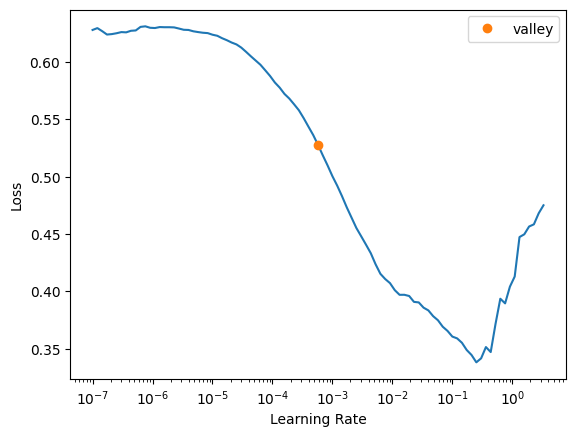

In [ ]:
# Charger le Learner sauvegardé
learn.load('stage0')

# Trouver le meilleur taux d'apprentissage
be je st_lr = learn.lr_find()

# Entraîner le modèle en utilisant le meilleur lr"
learn.fit_one_cycle(25, lr_max=best_lr)

# Sauvegarder le modèle après l'entraînement
learn.save('stage1')

## 6. Visualiser les résultats

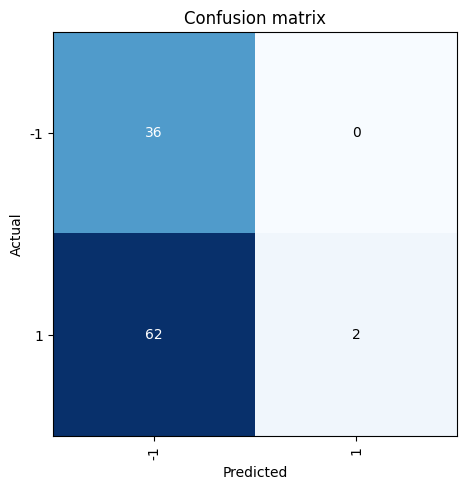

In [ ]:
# Matrice de confusion
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# Précision du modèle
valid_probas, valid_targets , valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
accuracy = (valid_targets == valid_preds).float().mean()
print("Précision du modèle : ")
print(accuracy)

Précision du modèle : 
tensor(0.3800)
